### Debug

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [204]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [2]:
import numpy as np
import random

##### Synthetic Data

In [245]:
def get_sin_wave(length, freq):
    t = np.arange(length)
    x = np.sin(2*np.pi * (1/freq) * t)
    return x

In [246]:
X_train = []
y_train = []
for i in range(300):
    example = (get_sin_wave(length=260, freq=random.randint(32, 64)).reshape(1, -1) + 2)/2
#     example = example.T
    start = 0
    end = start + 250
    pred_end = end + 10
    X_train.append(example[:, start:end])
    y_train.append(example[:, end:pred_end])

In [247]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

##### Real Data

In [248]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
dev_dataset_csv = settings.DEV_DATASET_CSV
real_train_dataset = EEGDataset(train_dataset_csv, 260, [1], max_num_examples=300, transform=normalize)

X_real_train = []
y_real_train = []
for i in range(300):
    example = real_train_dataset[i].numpy()
#     example = example.T
    start = 0
    end = start + 250
    pred_end = end + 10
    X_real_train.append(example[:, start:end])
    y_real_train.append(example[:, end:pred_end])

Found 2765 recordings
By set limit only using 300 recordings
Removing recordings of insufficient length...
Removed 0 of 300 recordings. There are now 300 recordings.


Process ForkPoolWorker-258:
Process ForkPoolWorker-260:
Process ForkPoolWorker-261:
Process ForkPoolWorker-263:
Process ForkPoolWorker-259:
Process ForkPoolWorker-262:
Process ForkPoolWorker-256:
Process ForkPoolWorker-267:
Process ForkPoolWorker-266:
Process ForkPoolWorker-257:
Process ForkPoolWorker-264:
Process ForkPoolWorker-265:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/mnt/home2/dlongo/.conda/envs/mne-4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    sel

In [249]:
X_train = np.asarray(X_real_train)
y_train = np.asarray(y_real_train)

#### Pytorch Model

In [221]:
import torch
import torch.nn as nn

In [516]:
class TorchLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=80, num_layers=2, output_size=1, n_predictions=10, dropout=.3):
        super().__init__()
        self.output_size = output_size
        self.n_predictions = n_predictions
#         self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.lstm1 = nn.LSTM(input_size, hidden_layer_size, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(p=.3)
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(p=.3)
#         self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_layer_size, n_predictions * output_size)

    def forward(self, input_seq):
        out, (_, _) = self.lstm1(input_seq)
        out = self.dropout1(out)
        out, (_, _) = self.lstm2(out)
        out = self.dropout2(out)
        preds = self.fc1(out[:,-1].squeeze()).squeeze()
        return preds
#         return self.relu(preds)
#     def forward(self, input_seq):
#         out, (h_n,_) = self.lstm(input_seq)
#         h_n = h_n[-1] # from last layer
#         h_n = h_n.squeeze()
#         preds = self.fc1(h_n).view(-1, self.n_predictions, self.output_size)
#         preds = self.fc1(out[:,-1,:].squeeze()).squeeze()
#         return preds



things to check
- initialization 
- check outputs vs keras

In [517]:
from torch.utils.data import TensorDataset, DataLoader

In [518]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [519]:
def train(num_epochs):
    torch_model.train()
    running_losses = []
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            a = torch_model(x.transpose(1,2))
            loss = criteron(a.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()
            
            running_losses.append(loss.item())
            if i % 10 == 0:
                cur_iter = len(train_loader) * epoch + i
                print(f"epoch {epoch} | iter {cur_iter} | Running Loss {sum(running_losses)/len(running_losses)}")
                running_losses.clear()

In [522]:
torch_model.summary()

AttributeError: 'TorchLSTM' object has no attribute 'summary'

In [520]:
torch_model = TorchLSTM(n_predictions=10, hidden_layer_size=80, num_layers=2)
criteron = nn.MSELoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=.001)

In [521]:
train(500)

epoch 0 | iter 0 | Running Loss 0.3154061734676361
epoch 1 | iter 5 | Running Loss 0.2690798431634903
epoch 2 | iter 10 | Running Loss 0.19070129096508026
epoch 3 | iter 15 | Running Loss 0.11907382905483246
epoch 4 | iter 20 | Running Loss 0.09414765685796737
epoch 5 | iter 25 | Running Loss 0.0832745149731636
epoch 6 | iter 30 | Running Loss 0.08106383085250854
epoch 7 | iter 35 | Running Loss 0.06573965251445771
epoch 8 | iter 40 | Running Loss 0.049335597455501555
epoch 9 | iter 45 | Running Loss 0.04430879727005958
epoch 10 | iter 50 | Running Loss 0.04627854749560356
epoch 11 | iter 55 | Running Loss 0.039071603864431384
epoch 12 | iter 60 | Running Loss 0.03867567703127861
epoch 13 | iter 65 | Running Loss 0.034839557483792305
epoch 14 | iter 70 | Running Loss 0.03724113777279854
epoch 15 | iter 75 | Running Loss 0.03327190652489662
epoch 16 | iter 80 | Running Loss 0.0336956575512886
epoch 17 | iter 85 | Running Loss 0.03290397301316261
epoch 18 | iter 90 | Running Loss 0.03203

In [481]:
torch_model.eval()
i = random.randint(0, X_train.shape[0])
example = X_train[i]
example = torch.from_numpy(example.reshape(1, 250, 1)).type('torch.FloatTensor')
pred = torch_model(example).detach().numpy()
combined = np.concatenate([example[0].numpy(), y_train[i].T], axis=0).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example.squeeze()),pred]).squeeze()

plt.plot(combined[-100:])
plt.plot(combined_zeros[-100:])

AttributeError: 'NoneType' object has no attribute 'detach'

In [436]:
example[0].shape

torch.Size([250, 1])

In [183]:
y_train[1].shape

(1, 10)

#### Keras Model

In [250]:
import tensorflow

In [251]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping, Callback
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
import numpy as np
import os

In [252]:
model = Sequential()

model.add(LSTM(
    80,
    input_shape=(None, X_train.shape[2]),
    return_sequences=True)
)

model.add(Dropout(.3))

model.add(LSTM(
    80,
    return_sequences=False)
)

model.add(Dropout(.3))

model.add(Dense(10))
model.add(Activation('linear'))

model.compile(loss='mse',
               optimizer='adam')

model.fit(X_train,
    y_train.squeeze(),
    batch_size=64,
    epochs=500,
    validation_split=.2,
)

Train on 240 samples, validate on 60 samples
Epoch 1/500
240/240 [==============================] - 1s 4ms/step - loss: 0.2761 - val_loss: 0.2136
Epoch 2/500
240/240 [==============================] - 0s 87us/step - loss: 0.2033 - val_loss: 0.1374
Epoch 3/500
240/240 [==============================] - 0s 83us/step - loss: 0.1303 - val_loss: 0.0901
Epoch 4/500
240/240 [==============================] - 0s 88us/step - loss: 0.1051 - val_loss: 0.0921
Epoch 5/500
240/240 [==============================] - 0s 93us/step - loss: 0.1026 - val_loss: 0.0849
Epoch 6/500
240/240 [==============================] - 0s 89us/step - loss: 0.0943 - val_loss: 0.0772
Epoch 7/500
240/240 [==============================] - 0s 88us/step - loss: 0.0921 - val_loss: 0.0741
Epoch 8/500
240/240 [==============================] - 0s 90us/step - loss: 0.0857 - val_loss: 0.0683
Epoch 9/500
240/240 [==============================] - 0s 100us/step - loss: 0.0815 - val_loss: 0.0609
Epoch 10/500
240/240 [===============

In [505]:
linear_activation = model = Sequential([Activation('linear')])

In [496]:
import tensorflow as tf

In [509]:
x = np.random.randn(4, 10, 20)
a = linear_activation.predict(tf.convert_to_tensor(x)).numpy()
print(np.sum(abs(x-a)))

ValueError: If your data is in the form of symbolic tensors, you should specify the `steps` argument (instead of the `batch_size` argument, because symbolic tensors are expected to produce batches of input data).

In [ ]:
# try initializing with same variables
# add pytest (read about it)
# try porting to torch
# try training keras model without fit function 
# https://stackoverflow.com/questions/56915567/keras-vs-pytorch-lstm-different-results

In [492]:
print(torch_model)

TorchLSTM(
  (lstm1): LSTM(1, 80, batch_first=True)
  (dropout1): Dropout(p=0.3)
  (lstm2): LSTM(80, 80, batch_first=True)
  (dropout2): Dropout(p=0.3)
  (fc1): Linear(in_features=80, out_features=10, bias=True)
)


In [391]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, None, 80)          105920    
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 80)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 80)                51520     
_________________________________________________________________
dropout_12 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                810       
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 158,250
Trainable params: 158,250
Non-trainable params: 0
________________________________________________

In [488]:
print(model.)

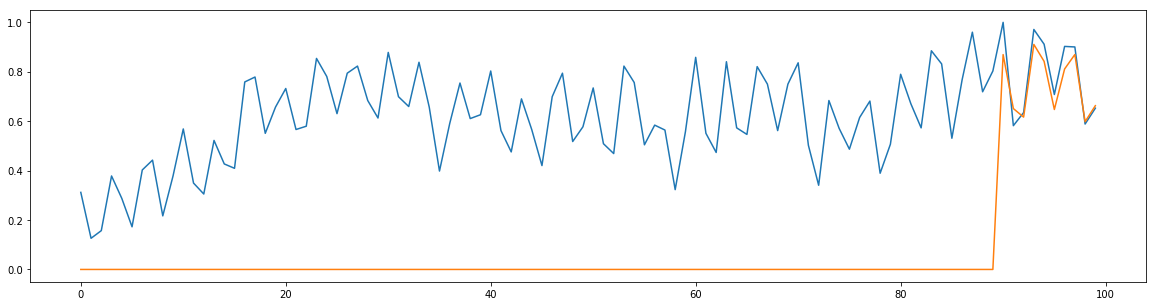

In [295]:
i = random.randint(0, X_train.shape[0])
example = X_train[i]
pred = model.predict(example.reshape(1,1,-1))
combined = np.concatenate([example,y_train[i]], axis=1).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example),pred], axis=1).squeeze()

plt.plot(combined[-100:])
plt.plot(combined_zeros[-100:])

In [ ]:
torch_model.eval()
i = random.randint(0, X_train.shape[0])
example = X_train[i]
example = torch.from_numpy(example.reshape(1, 250, 1)).type('torch.FloatTensor')
pred = torch_model(example).detach().numpy()
combined = np.concatenate([example[0].numpy(), y_train[i].T], axis=0).squeeze()
combined_zeros = np.concatenate([np.zeros_like(example),pred], axis=1).squeeze()

plt.plot(combined[-50:])
plt.plot(combined_zeros[-50:])

In [165]:
import torch
from torch.utils.data import Dataset
from dynaconf import settings
import pandas as pd
from progress.bar import ChargingBar
import multiprocessing as mp

import h5py
import pandas as pd
import torch

def load_eeg_file(filename):
    hdf = h5py.File(filename, "r")
    rec = hdf["record-0"]
    signals = rec["signals"]
    specs = {
        "sample_frequency": rec.attrs["sample_frequency"],
        "number_channels": rec.attrs["number_channels"]
    }
    return signals, specs

def get_recordings_df(csv_file, max_num_examples, print_results_info=True):
        recordings_df = pd.read_csv(csv_file)
        if print_results_info:
            print(f"Found {len(recordings_df)} recordings")

        if max_num_examples is not None:
            recordings_df = recordings_df[:max_num_examples]
            if print_results_info:
                print(f"By set limit only using {len(recordings_df)} recordings")
        
        return recordings_df
    
def normalize(x):
    x_range = x.max()-x.min()
    if x_range == 0:
        return torch.zeros_like(x)
    return (x-x.min())/x_range


class EEGDataset(Dataset):

    def __init__(self, csv_file, length, select_channels, max_num_examples=None, root_dir=None, transform=None, remove_short_recordings=True, filter_freq=False):

        if root_dir is None:
            self.root_dir = settings.DATASET_DIR
        else:
            self.root_dir = root_dir

        self.recordings_df = get_recordings_df(csv_file, max_num_examples)
        self.length = length
        self.select_channels = select_channels
        self.transform = transform
        self.filter_freq = filter_freq

        if remove_short_recordings:
            self.remove_recordings_too_short()

    def __len__(self):
        return len(self.recordings_df)

    def __getitem__(self, idx):
        filename, start_pos = self.recordings_df.iloc[idx, :2]
        signals, _  = load_eeg_file(filename)

        # only keep selected channels
        signals = signals[self.select_channels]
        # only output selected portion
        signals = signals[:, start_pos: start_pos + self.length]
        
#         if self.filter_freq:
#             signals = butter_lowpass_filter2(signals, cutoff=settings.LOW_PASS_FILTER_CUTOFF, fs=settings.FREQUENCY).copy()

        signals = torch.from_numpy(signals).type('torch.FloatTensor')
        if self.transform:
            signals = self.transform(signals)

        return signals

    def recording_is_sufficient_length(self, idx):
        # returns idx if insufficient otherwise None
        cur_recording = self.__getitem__(idx)
        if cur_recording.shape[1] != self.length:
            return idx
        return None
    
    def remove_recordings_too_short(self):

        print("Removing recordings of insufficient length...")
        original_len = self.__len__()

        pool = mp.Pool(mp.cpu_count())
        remove_indices = pool.map(self.recording_is_sufficient_length, list(range(original_len)))
        remove_indices = [i for i in remove_indices if i is not None] # remove all nones

        self.recordings_df = self.recordings_df.drop(remove_indices)
        print(f"Removed {len(remove_indices)} of {original_len} recordings. There are now {self.__len__()} recordings.")
